$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Convolutional Architectures
<a id=part3></a>

In this assignment we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on CIFAR-10.


In [69]:
!pip install tqdm==4.17.1

In [70]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from google.colab import drive
drive.mount('/content/drive') 
#change this
%cd /content/drive/MyDrive/Deep Learning/Assignment 2/CNN
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Deep Learning/Assignment 2/CNN


## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we already saw, convolutional layers operate on and produce volumes (3D tensors) of activations.


One way to interpret convolutional layers is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

![picture](https://sci2lab.github.io/ml_tutorial/images/cnn_convolution_3.png)

A crucial property of convolutional layers is their translation invariance,
i.e. their ability to detect features regardelss of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ReLU)*P -> MaxPool]*(N/P) -> (Linear -> ReLU)*M -> Linear

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `utils/models.py` module.

In [72]:
from  utils import models
torch.manual_seed(seed)

net = models.ConvClassifier((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_conv_out.pt').to(device)
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-5)

ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 

**Note about running on GPUs**.

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [73]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are therefore also on device={next(net.parameters()).device}')
print(f'The test image is therefore also on device={test_image.device}')

This notebook is running with device=cuda
The model parameter tensors are therefore also on device=cuda:0
The test image is therefore also on device=cuda:0


Let's load CIFAR-10 again to use as our dataset.

In [74]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `utils/training.py` module. 
You should implement the funcitons:
* fit (...)
* train_batch(...)
* test_batch(...)

In [75]:
import utils.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = models.ConvClassifier(in_size, num_classes, filters=[32], pool_every=1, hidden_dims=[100])
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(22):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
train_batch (Avg. Loss 0.257, Accuracy 96.0): 100%|██████████| 25/25 [00:00<00:00, 172.19it/s]


## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### General notes for running experiments

- It's important to give each experiment run a name as specified by the notebook instructions later on. The each run has a `run_name` parameter that will also be the name of the results file which this notebook will expect to load.

- You will implement the code to run the experiments in the `utils/experiments.py` module. 

### Experiment 1 - Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. The feature-extraction part of our model will therefore be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->MaxPool->Conv(32,64)->ReLU->Conv(64,64)->ReLU->MaxPool
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. 

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `utils/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
--- EPOCH 1/10 ---
test_batch (Avg. Loss 1.316, Accuracy 54.2): 100%|██████████| 625/625 [00:02<00:00, 223.27it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 1.280, Accuracy 53.9): 100%|██████████| 625/625 [00:02<00:00, 242.47it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.178, Accuracy 58.0): 100%|██████████| 625/625 [00:02<00:00, 232.19it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 1.153, Accuracy 58.8): 100%|██████████| 625/625 [00:02<00:00, 225.76it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 1.123, Accuracy 59.7

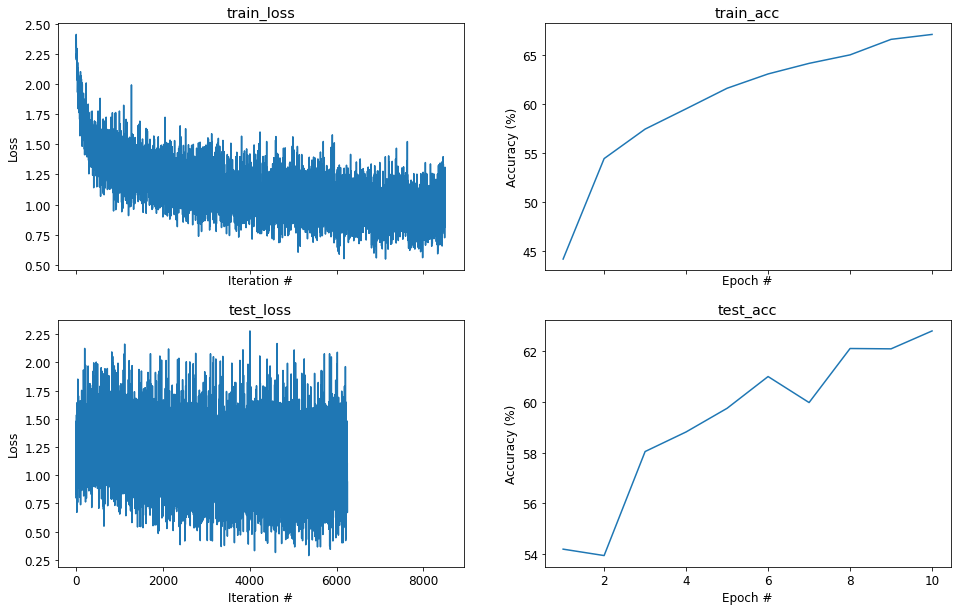

In [76]:
import utils.experiments as experiments
from utils.experiments import load_experiment
from utils.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment('test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                           filters_per_layer=[32], layers_per_block=1, pool_every=1, hidden_dims=[100])

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [68]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_K{}_L{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_K32_L2`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

In [77]:
import utils.experiments as experiments
from utils.experiments import load_experiment
from utils.plot import plot_fit

In [79]:
for l in [2,4,8,16]:
    # Test experiment1 implementation on a few data samples and with a small model
    experiments.run_experiment(f'exp1_1_K32_L{l}',
                               seed=seed,
                               bs_train=50,
                               batches=10000,
                               epochs=30, 
                               early_stopping=5,
                               reg=2e-3,
                               lr=1e-3,
                               filters_per_layer=[32],
                               layers_per_block=l,
                               pool_every=4,
                               hidden_dims=[100, 100])


Files already downloaded and verified
Files already downloaded and verified
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
--- EPOCH 1/30 ---
test_batch (Avg. Loss 1.403, Accuracy 49.9): 100%|██████████| 625/625 [00:02<00:00, 204.00it/s]
--- EPOCH 2/30 ---
test_batch (Avg. Loss 1.326, Accuracy 51.9): 100%|██████████| 625/625 [00:02<00:00, 219.79it/s]
--- EPOCH 3/30 ---
test_batch (Avg. Loss 1.205, Accuracy 56.7): 100%|██████████| 625/625 [00:02<00:00, 211.76it/s]
--- EPOCH 4/30 ---
test_batch (Avg. Loss 1.175, Accuracy 58.0): 100%|██████████| 625/625 [

common config:  {'run_name': 'exp1_1_K32_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10000, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.002, 'pool_every': 4, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


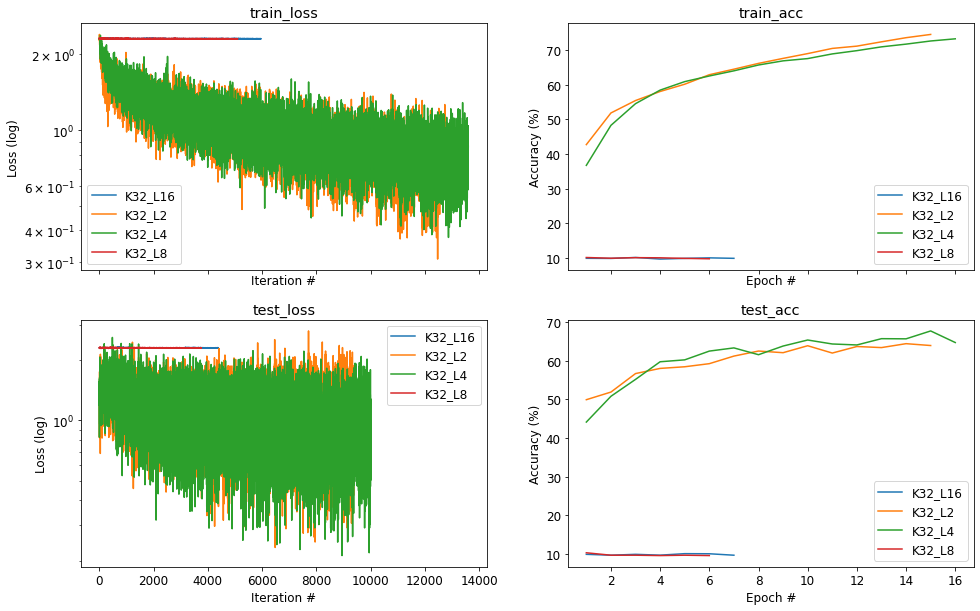

In [80]:
plot_exp_results('exp1_1_K32*.json')

In [81]:
for l in [2,4,8,16]:
    # Test experiment1 implementation on a few data samples and with a small model
    experiments.run_experiment(f'exp1_1_K64_L{l}',
                               seed=seed,
                               bs_train=50,
                               batches=10000,
                               epochs=30, 
                               early_stopping=5,
                               reg=2e-3,
                               lr=1e-3,
                               filters_per_layer=[64],
                               layers_per_block=l,
                               pool_every=4,
                               hidden_dims=[100, 100])
    


Files already downloaded and verified
Files already downloaded and verified
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
--- EPOCH 1/30 ---
test_batch (Avg. Loss 1.319, Accuracy 52.4): 100%|██████████| 625/625 [00:03<00:00, 197.80it/s]
--- EPOCH 2/30 ---
test_batch (Avg. Loss 1.195, Accuracy 56.6): 100%|██████████| 625/625 [00:03<00:00, 195.86it/s]
--- EPOCH 3/30 ---
test_batch (Avg. Loss 1.193, Accuracy 57.7): 100%|██████████| 625/625 [00:03<00:00, 196.09it/s]
--- EPOCH 4/30 ---
test_batch (Avg. Loss 1.156, Accuracy 57.6): 100%|██████████| 625/625 [

common config:  {'run_name': 'exp1_1_K64_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10000, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.002, 'pool_every': 4, 'hidden_dims': [100, 100], 'ycn': False, 'kw': {}}


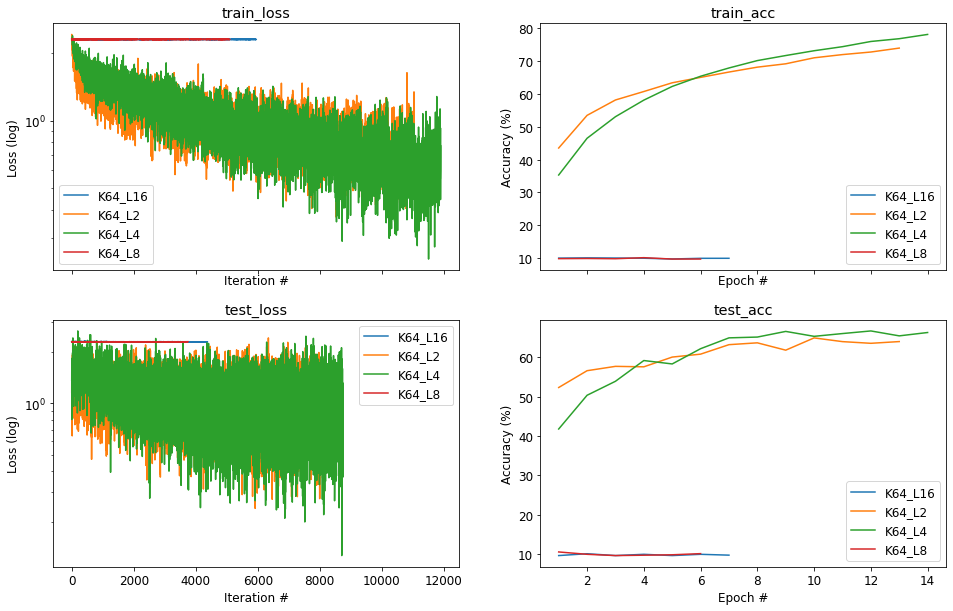

In [82]:
plot_exp_results('exp1_1_K64*.json')

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.


**ANSWER**:

1. The optimal depth is four layers. From the graph, we can infer that as we add layers, the accuracy increases, until we increase the depth too much. Thus, there is a lot of maxPooling layers, which results in inputs that are too small for learning.

2. The network wasn't trainable for L - 8,16. This is because with this depth, with the same *every_pooling* value, there are a lot of maximum pool layers, decreasing the input size too much.

Suggestions for partially resolve: 


*   **Limit the max pool layers** - Max pool layers can be limited. Limits will be calculated based on the input size - for example, allow pooling until the size is 1/8 (h,w) of the original. 
*   **Increase the gap between max pool layers**  - increase the gap between max pool layers based on **L**. 



**Extra Points:** 

Try solve the problem we saw, using your suggestions. implement it in utils/model.py/YourCodeNet and run again (one of the) experiments where the model wasn't trained to see if the problem have solved).


In [ ]:
###### Extra Points ######
# run again (one of the) experiments where the model wasn't trained at all,
# but use YourCodeNet to see if your implemented suggestions fixed the problem.
# set ycn=True when you call experiments.run_experiment(...)
# ====== YOUR CODE: ======
# it is recommended to use loops in order to run all experiments.
# ========================
# experiments.run_experiment('exp1_1_K32_L8_extra_points',
#                             seed=seed,
#                             bs_train=50,
#                             batches=10000,
#                             epochs=30, 
#                             early_stopping=5,
#                             reg=2e-3,
#                             lr=1e-3,
#                             filters_per_layer=[32],
#                             layers_per_block=8,
#                             pool_every=4,
#                             hidden_dims=[100, 100])


#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[256]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

In [ ]:
for l in [2,4,8]:
    for k in [32,64,128,256]:
        # Test experiment1 implementation on a few data samples and with a small model
        experiments.run_experiment(f'exp1_2_L{l}_K{k}',
                                   seed=seed,
                                   bs_train=50,
                                   batches=10000,
                                   epochs=30, 
                                   early_stopping=5,
                                   reg=2e-3,
                                   lr=1e-3,
                                   filters_per_layer=[k],
                                   layers_per_block=l,
                                   pool_every=4, 
                                   hidden_dims=[100, 100])


Files already downloaded and verified
Files already downloaded and verified
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
--- EPOCH 1/30 ---
test_batch (Avg. Loss 1.392, Accuracy 50.0): 100%|██████████| 625/625 [00:02<00:00, 208.65it/s]
--- EPOCH 2/30 ---
test_batch (Avg. Loss 1.314, Accuracy 52.3): 100%|██████████| 625/625 [00:02<00:00, 212.65it/s]
--- EPOCH 3/30 ---
test_batch (Avg. Loss 1.194, Accuracy 56.9): 100%|██████████| 625/625 [00:02<00:00, 210.92it/s]
--- EPOCH 4/30 ---
test_batch (Avg. Loss 1.174, Accuracy 57.5): 100%|██████████| 625/625 [

In [ ]:
plot_exp_results('exp1_2_L2*.json')

In [ ]:
plot_exp_results('exp1_2_L4*.json')

In [ ]:
plot_exp_results('exp1_2_L8*.json')

### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1. For a spesific value of L, how the preformance change with respect to K? Does we saw the same phenomena in 1.1 for a spresific value of K?

**ANSWER**: